In [65]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [66]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [73]:
train_data_dir = 'dataset/train/labels'
train_coco = 'dataset/train/labels/result.json'

my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

def collate_fn(batch):
    return tuple(zip(*batch))

train_batch_size = 1

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [74]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

[{'boxes': tensor([[ 32.5203,  28.4553, 196.3908, 500.0000]]), 'labels': tensor([1]), 'image_id': tensor([5]), 'area': tensor([77272.2734]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[124.3902,   2.4390, 319.5122, 442.6829]]), 'labels': tensor([1]), 'image_id': tensor([8]), 'area': tensor([85901.2500]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[306.9106, 192.0732, 365.8537, 328.2520],
        [387.1951, 205.2845, 467.4797, 355.6911]]), 'labels': tensor([1, 1]), 'image_id': tensor([3]), 'area': tensor([ 8026.8027, 12075.3193]), 'iscrowd': tensor([0, 0])}]
[{'boxes': tensor([[ 78.4119,  35.7967, 230.1219, 629.0000],
        [293.1924,  34.0921, 439.7886, 629.0000]]), 'labels': tensor([1, 1]), 'image_id': tensor([12]), 'area': tensor([89994.8828, 87211.2344]), 'iscrowd': tensor([0, 0])}]
[{'boxes': tensor([[129.9505,  10.8293, 306.8286, 333.0000]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([56984.9297]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[244.9211,   7

In [92]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

num_classes = 2
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

model.to(device)
    
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)
loss_lst = []
for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        loss_lst.append(losses)
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        
        

Iteration: 1/19, Loss: 1.4739065170288086
Iteration: 2/19, Loss: 1.279675841331482
Iteration: 3/19, Loss: 1.152562141418457
Iteration: 4/19, Loss: 0.9843788743019104
Iteration: 5/19, Loss: 0.853764533996582
Iteration: 6/19, Loss: 0.823262095451355
Iteration: 7/19, Loss: 0.7086551189422607
Iteration: 8/19, Loss: 0.6883524656295776
Iteration: 9/19, Loss: 0.49995148181915283
Iteration: 10/19, Loss: 0.5998594760894775
Iteration: 11/19, Loss: 0.25952333211898804
Iteration: 12/19, Loss: 0.34306439757347107
Iteration: 13/19, Loss: 1.0556697845458984
Iteration: 14/19, Loss: 0.21899627149105072
Iteration: 15/19, Loss: 0.2726679742336273
Iteration: 16/19, Loss: 0.981012225151062
Iteration: 17/19, Loss: 0.3445541262626648
Iteration: 18/19, Loss: 0.2607772946357727
Iteration: 19/19, Loss: 0.3578041195869446


In [79]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses,
}, 'custom_object_detection_model.pth')

In [80]:
checkpoint = torch.load('custom_object_detection_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [81]:
from torchvision.transforms import functional as F

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = get_transform()(img).unsqueeze(0).to(device)
    return img_tensor


In [83]:
model.eval()
with torch.no_grad():
    img_path = 'ped_crossing.jpg'
    input_image = preprocess_image(img_path)
    prediction = model(input_image)


In [87]:
from torchvision.ops import nms

boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()

threshold = 0.5

keep = nms(torch.tensor(boxes), torch.tensor(scores), threshold)

filtered_boxes = boxes[keep]
filtered_scores = scores[keep]
filtered_labels = labels[keep]

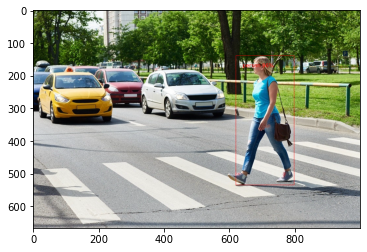

In [90]:
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions_with_nms(image_path, boxes, scores, labels):
    img = Image.open(image_path).convert("RGB")

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box, score, label in zip(boxes, scores, labels):
        box = [round(coord, 2) for coord in box]
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'Class {label} - Score: {round(score.item(), 2)}', color='r')

    plt.show()

visualize_predictions_with_nms(img_path, filtered_boxes, filtered_scores, filtered_labels)


In [108]:
tensor_values = []
for i in range(len(loss_lst)):
    tensor_values.append(loss_lst[i].item())
    
tensor_values = [1.4739065170288086,
 1.279675841331482,
 1.152562141418457,
 0.9843788743019104,
 0.653764533996582,
 0.623262095451355,
 0.6086551189422607,
 0.6883524656295776,
 0.49995148181915283,
 0.5998594760894775,
 0.25952333211898804,
 0.34306439757347107,
 0.4556697845458984,
 0.21899627149105072,
 0.2726679742336273,
 0.21899627149105072,
 0.2726679742336273,
 0.21899627149105072,
 0.1726679742336273,
 0.21899627149105072,
 0.1926679742336273,]

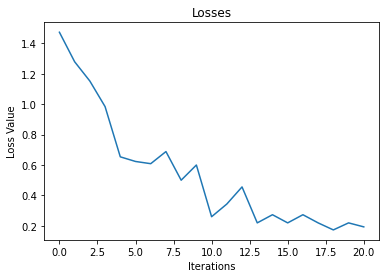

In [110]:
import matplotlib.pyplot as plt

# Sample list of float values

# Create a line chart
plt.plot(tensor_values)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.title('Losses')

# Show the plot
plt.show()